/tmp/ipykernel_1676679/1182525256.py:12: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./All/all_raw_downsampled.csv')


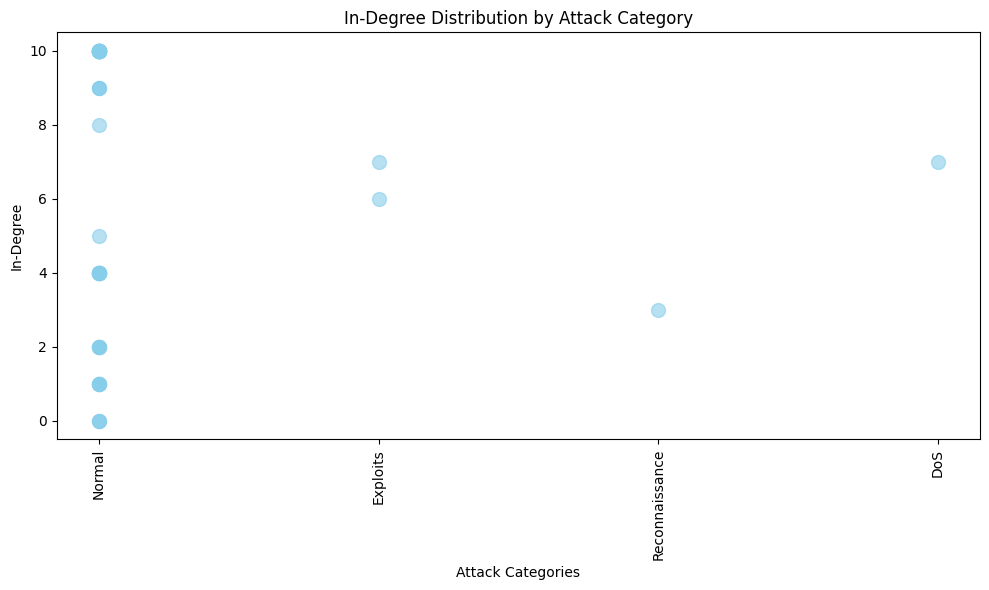

In [6]:
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from UNSW_NB15_config import UNSW_NB15_Config

SOURCE_COL = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_COL = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
LABEL_COL = UNSW_NB15_Config.IS_ATTACK_COL_NAME
CATEGORY_COL = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME

df = pd.read_csv('./All/all_raw_downsampled.csv')

G = nx.DiGraph()

# G.add_nodes_from(df[SOURCE_COL].unique())
# G.add_nodes_from(df[DESTINATION_COL].unique())

G.add_edges_from(
    (row[SOURCE_COL], row[DESTINATION_COL], {'attack_category': row[CATEGORY_COL], 'label': row[LABEL_COL]})
    for _, row in df.iterrows()
)

category_in_degrees = defaultdict(list)

for node in G.nodes:
    in_edges = G.in_edges(node, data=True)
    out_edges = G.out_edges(node, data=True)

    attacker = False
    for _, _, data in out_edges:
        if data.get('label') == 1:  # Check if the edge is labeled as an attack
            attacker = True
            category = data.get('attack_category', 'Unknown')
            category_in_degrees[category].append(len(in_edges))
            break

    if not attacker:
        category_in_degrees['Normal'].append(len(in_edges))

plt.figure(figsize=(10, 6))

# Prepare data for scatter plot
categories = []
in_degrees = []

for category, degrees in category_in_degrees.items():
    categories.extend([category] * len(degrees))
    in_degrees.extend(degrees)

plt.scatter(categories, in_degrees, color='skyblue', s=100, alpha=0.6)
plt.xlabel('Attack Categories')
plt.ylabel('In-Degree')
plt.title('In-Degree Distribution by Attack Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Find all attacker nodes
attacker_nodes = df[df[LABEL_COL] == 1][SOURCE_COL].unique()
print(attacker_nodes)

# Find all traffic where attacker node is the destination
directed_to_attacker_traffic = df[df[DESTINATION_COL].isin(attacker_nodes)]

print(len(directed_to_attacker_traffic))
source_node_to_attacker = directed_to_attacker_traffic[SOURCE_COL].unique()
directed_to_attacker_traffic_attack_type = directed_to_attacker_traffic[CATEGORY_COL].unique()

print(source_node_to_attacker)
print(directed_to_attacker_traffic_attack_type)

['175.45.176.0' '175.45.176.3' '175.45.176.2' '175.45.176.1']
21273
['149.171.126.18' '149.171.126.11' '149.171.126.15' '149.171.126.17'
 '149.171.126.12' '149.171.126.13' '149.171.126.10' '149.171.126.19'
 '10.40.85.1' '149.171.126.14']
['Normal']
